开始加载数据...
数据加载完成，开始分析...
正在进行连通域分析...
检测到建筑物数量: 6740

正在计算建筑物大小...


处理建筑物: 100%|██████████| 6740/6740 [12:38<00:00,  8.88it/s]



正在生成统计信息...

基础统计 (像素单位):
最小建筑物大小: 12 pixels (108.0 m²)
最大建筑物大小: 180313 pixels (1622817.0 m²)
平均建筑物大小: 512.2 pixels (4609.6 m²)
中位数建筑物大小: 150.0 pixels (1350.0 m²)

分位数统计:
5分位数: 80.0 pixels (720.0 m²)
10分位数: 90.0 pixels (810.0 m²)
25分位数: 111.0 pixels (999.0 m²)
50分位数: 150.0 pixels (1350.0 m²)
75分位数: 334.2 pixels (3008.2 m²)
90分位数: 1242.1 pixels (11178.9 m²)
95分位数: 2117.0 pixels (19053.4 m²)

正在生成可视化图表...


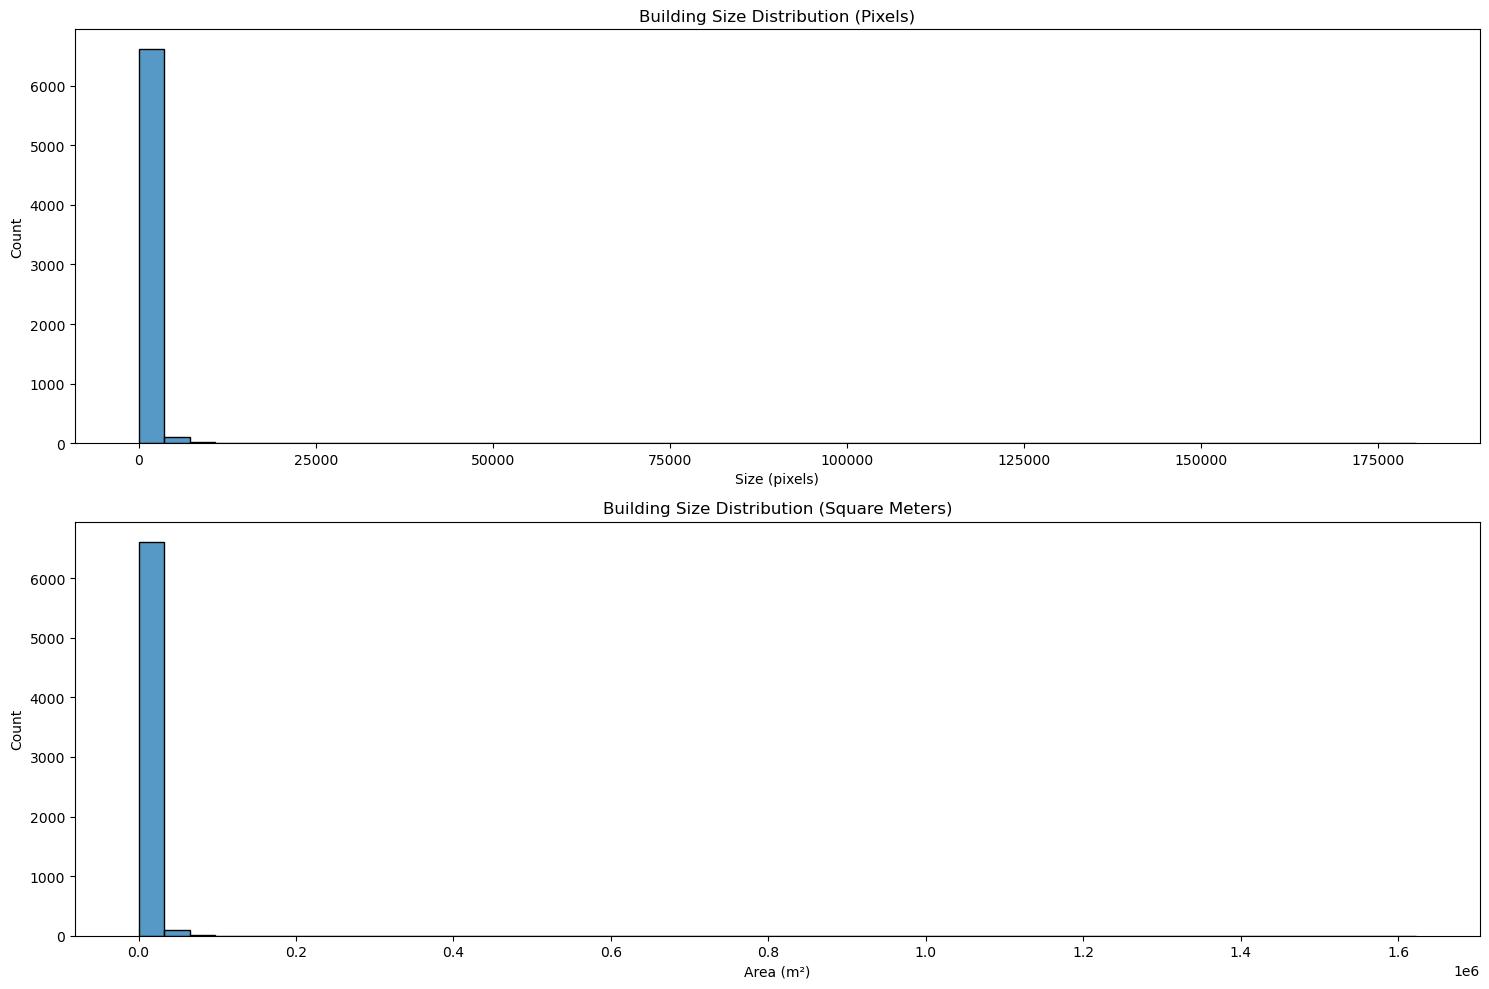


正在生成空间分布图...


生成空间分布图: 100%|██████████| 6740/6740 [15:10<00:00,  7.41it/s]


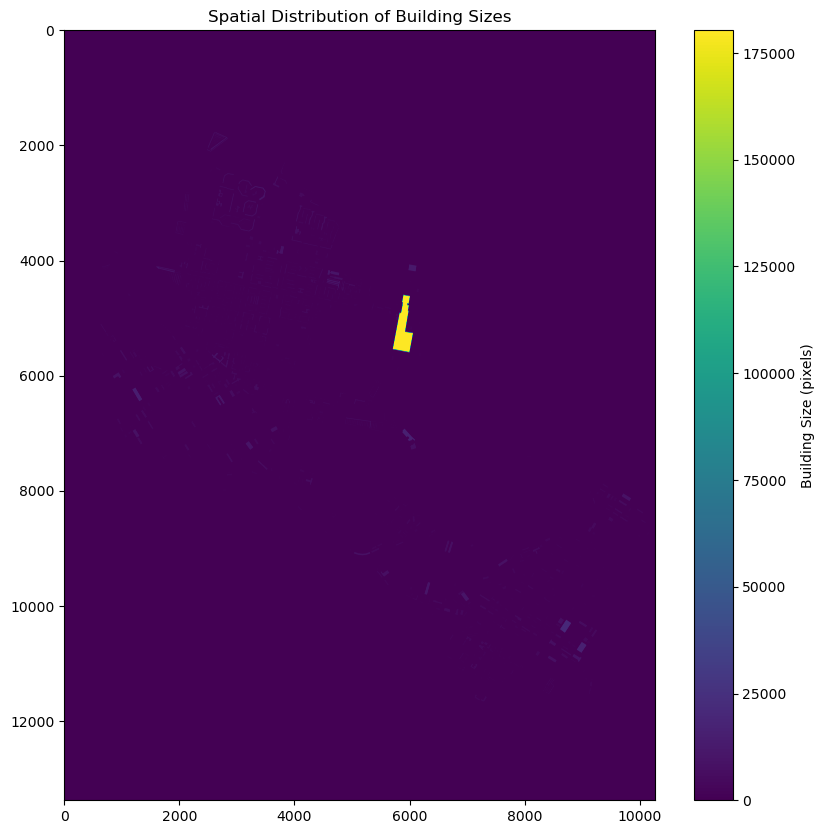


建议的阈值:
像素数: 111.0
实际面积: 999.0 m²
使用该阈值时，24.4%的建筑物会被标记为小型建筑


In [8]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure
import seaborn as sns
from pathlib import Path
import logging
from tqdm import tqdm
Image.MAX_IMAGE_PIXELS = None  # 取消图像大小限制

logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# pixel_to_area函数保持不变...

def analyze_building_sizes(building_mask, resolution=3.0):
    """
    分析建筑物大小分布
    
    Args:
        building_mask: 二值化的建筑物mask图像
        resolution: 图像分辨率（米/像素）
    """
    # 连通域分析
    print("正在进行连通域分析...")
    building_labels = measure.label(building_mask)
    num_buildings = building_labels.max()
    print(f"检测到建筑物数量: {num_buildings}")
    
    # 收集建筑物大小
    print("\n正在计算建筑物大小...")
    sizes = []
    # 使用tqdm创建进度条
    for building_id in tqdm(range(1, num_buildings + 1), desc="处理建筑物"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        sizes.append(size)
    
    sizes = np.array(sizes)
    
    print("\n正在生成统计信息...")
    # 基础统计
    print("\n基础统计 (像素单位):")
    print(f"最小建筑物大小: {sizes.min()} pixels ({pixel_to_area(sizes.min(), resolution):.1f} m²)")
    print(f"最大建筑物大小: {sizes.max()} pixels ({pixel_to_area(sizes.max(), resolution):.1f} m²)")
    print(f"平均建筑物大小: {sizes.mean():.1f} pixels ({pixel_to_area(sizes.mean(), resolution):.1f} m²)")
    print(f"中位数建筑物大小: {np.median(sizes):.1f} pixels ({pixel_to_area(np.median(sizes), resolution):.1f} m²)")
    
    # 计算分位数
    percentiles = [5, 10, 25, 50, 75, 90, 95]
    print("\n分位数统计:")
    for p in percentiles:
        value = np.percentile(sizes, p)
        print(f"{p}分位数: {value:.1f} pixels ({pixel_to_area(value, resolution):.1f} m²)")
    
    print("\n正在生成可视化图表...")
    # 绘图
    plt.figure(figsize=(15, 10))
    
    # 1. 大小分布直方图
    plt.subplot(2, 1, 1)
    sns.histplot(sizes, bins=50)
    plt.title('Building Size Distribution (Pixels)')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Count')
    
    # 2. 面积分布直方图（平方米）
    plt.subplot(2, 1, 2)
    areas = [pixel_to_area(s, resolution) for s in sizes]
    sns.histplot(areas, bins=50)
    plt.title('Building Size Distribution (Square Meters)')
    plt.xlabel('Area (m²)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    print("\n正在生成空间分布图...")
    # 额外的可视化：建筑物大小的空间分布
    plt.figure(figsize=(10, 10))
    building_sizes = np.zeros_like(building_labels, dtype=float)
    for building_id in tqdm(range(1, num_buildings + 1), desc="生成空间分布图"):
        building_mask = building_labels == building_id
        building_sizes[building_mask] = np.sum(building_mask)
    
    plt.imshow(building_sizes, cmap='viridis')
    plt.colorbar(label='Building Size (pixels)')
    plt.title('Spatial Distribution of Building Sizes')
    plt.show()
    
    return sizes

# suggest_threshold函数保持不变...

# 主执行部分
print("开始加载数据...")
try:
    # 加载mask
    mask = np.array(Image.open(building_mask_path))
    if mask.ndim > 2:
        print("检测到多通道图像，转换为单通道...")
        mask = mask[:,:,0]  # 如果是多通道，取第一个通道
    mask = mask > 0  # 二值化
    print("数据加载完成，开始分析...")
    
    # 分析建筑物大小分布
    sizes = analyze_building_sizes(mask, resolution)
    
    # 获取建议的阈值
    suggested_threshold = suggest_threshold(sizes, resolution)
    
except Exception as e:
    print(f"分析过程中出现错误: {e}")

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure
import seaborn as sns
from pathlib import Path
import logging
from tqdm import tqdm
from scipy import stats

# Basic configurations
Image.MAX_IMAGE_PIXELS = None  # Remove image size limit
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# Set font for plotting
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

def pixel_to_area(pixels, resolution=3.0):
    """
    Convert pixel count to actual area (square meters)
    
    Args:
        pixels: number of pixels
        resolution: resolution (meters/pixel)
    """
    return pixels * (resolution ** 2)

def analyze_building_sizes(building_mask, resolution=3.0):
    """
    Analyze building size distribution, handling outliers
    
    Args:
        building_mask: binary building mask image
        resolution: image resolution (meters/pixel)
    """
    # Connected component analysis
    print("Performing connected component analysis...")
    building_labels = measure.label(building_mask)
    num_buildings = building_labels.max()
    print(f"Detected building count: {num_buildings}")
    
    # Collect building sizes
    print("\nCalculating building sizes...")
    sizes = []
    for building_id in tqdm(range(1, num_buildings + 1), desc="Processing buildings"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        sizes.append(size)
    
    sizes = np.array(sizes)
    areas = np.array([pixel_to_area(s, resolution) for s in sizes])
    
    # Calculate outlier boundaries
    Q1 = np.percentile(sizes, 25)
    Q3 = np.percentile(sizes, 75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    # Separate normal values and outliers
    normal_sizes = sizes[sizes <= upper_bound]
    outlier_sizes = sizes[sizes > upper_bound]
    normal_areas = areas[sizes <= upper_bound]
    outlier_areas = areas[sizes > upper_bound]
    
    print("\nStatistics:")
    print(f"Total number of buildings: {len(sizes)}")
    print(f"Number of normal buildings: {len(normal_sizes)}")
    print(f"Number of outliers: {len(outlier_sizes)}")
    
    # Create multi-subplot visualization
    plt.figure(figsize=(15, 15))
    
    # 1. Original distribution (with outlier marking)
    plt.subplot(3, 1, 1)
    sns.histplot(data=areas, bins=50, color='blue', alpha=0.5, label='All Buildings')
    plt.axvline(pixel_to_area(upper_bound, resolution), color='red', linestyle='--', 
                label='Outlier Threshold')
    plt.title('Complete Building Size Distribution')
    plt.xlabel('Area (m²)')
    plt.ylabel('Count')
    plt.legend()
    
    # 2. Normal value distribution (outliers removed)
    plt.subplot(3, 1, 2)
    sns.histplot(data=normal_areas, bins=50, color='green', alpha=0.5)
    plt.title('Building Size Distribution (Outliers Removed)')
    plt.xlabel('Area (m²)')
    plt.ylabel('Count')
    
    # 3. Logarithmic scale distribution
    plt.subplot(3, 1, 3)
    sns.histplot(data=np.log10(areas), bins=50, color='purple', alpha=0.5)
    plt.title('Building Size Distribution (Logarithmic Scale)')
    plt.xlabel('Log10(Area) (m²)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Box plot visualization
    plt.figure(figsize=(10, 6))
    plt.boxplot(areas, vert=False, whis=1.5)
    plt.title('Building Size Box Plot')
    plt.xlabel('Area (m²)')
    plt.show()
    
    # Statistical summary
    print("\nNormal Value Statistics (After Removing Outliers):")
    print(f"Minimum area: {normal_areas.min():.1f} m²")
    print(f"Maximum area: {normal_areas.max():.1f} m²")
    print(f"Mean area: {normal_areas.mean():.1f} m²")
    print(f"Median area: {np.median(normal_areas):.1f} m²")
    
    # Spatial distribution plot (using logarithmic scale)
    plt.figure(figsize=(10, 10))
    building_sizes = np.zeros_like(building_labels, dtype=float)
    for building_id in tqdm(range(1, num_buildings + 1), desc="Generating spatial distribution"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        building_sizes[building_mask] = np.log10(size) if size > 0 else 0
    
    plt.imshow(building_sizes, cmap='viridis')
    plt.colorbar(label='Log10(Building Size) (pixels)')
    plt.title('Building Size Spatial Distribution (Logarithmic Scale)')
    plt.show()
    
    return sizes, normal_sizes, outlier_sizes

# Main execution
# Replace with your mask file path
building_mask_path = "../buildingmasks/mask_Rubizhne.tif"

print("Starting data loading...")
try:
    # Load mask
    mask = np.array(Image.open(building_mask_path))
    if mask.ndim > 2:
        print("Detected multi-channel image, converting to single channel...")
        mask = mask[:,:,0]  # If multi-channel, take the first channel
    mask = mask > 0  # Binarize
    print("Data loading complete, starting analysis...")
    
    # Analyze building size distribution
    sizes, normal_sizes, outlier_sizes = analyze_building_sizes(mask, resolution=3.0)
    
except Exception as e:
    print(f"Error occurred during analysis: {e}")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure

def show_fixed_threshold(image_path, mask_path, threshold=1000):
    """
    显示大于指定阈值的建筑物分布
    Args:
        image_path: 原始图像路径
        mask_path: 建筑物掩码路径
        threshold: 建筑物面积阈值（显示大于此阈值的建筑）
    """
    # 直接加载图像
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    
    # 创建图形
    plt.figure(figsize=(20, 6))
    
    # 1. 显示原始图像
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # 2. 显示所有建筑
    plt.subplot(132)
    plt.imshow(image)
    plt.imshow(mask > 0, alpha=0.3, cmap='cool')
    plt.title('All Buildings')
    plt.axis('off')
    
    # 3. 处理并显示大型建筑
    plt.subplot(133)
    building_labels = measure.label(mask)
    large_buildings = np.zeros_like(mask, dtype=bool)
    
    # 统计信息
    large_count = 0
    total_large_area = 0
    all_sizes = []
    
    for building_id in range(1, building_labels.max() + 1):
        current_mask = building_labels == building_id
        building_size = np.sum(current_mask)
        all_sizes.append(building_size)
        
        if building_size >= threshold:  # 大于等于阈值
            large_buildings |= current_mask
            large_count += 1
            total_large_area += building_size
    
    # 只显示大型建筑的掩码，不显示背景图像
    plt.imshow(large_buildings, cmap='hot')
    plt.title(f'Large Buildings (>={threshold} pixels, Count: {large_count})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\nBuilding Statistics (Threshold: {threshold} pixels):")
    print(f"Number of Large Buildings (>={threshold} pixels): {large_count}")
    print(f"Total Number of Buildings: {len(all_sizes)}")
    print(f"Proportion of Large Buildings: {large_count/len(all_sizes)*100:.1f}%")
    if large_count > 0:
        print(f"Average Area of Large Buildings: {total_large_area/large_count:.2f} pixels")
    print(f"Average Area of All Buildings: {np.mean(all_sizes):.2f} pixels")
    print(f"Minimum Building Area: {min(all_sizes)} pixels")
    print(f"Maximum Building Area: {max(all_sizes)} pixels")
    
    # 显示面积分布直方图，只显示小于阈值的建筑
    plt.figure(figsize=(10, 4))
    sizes_under_threshold = [size for size in all_sizes if size < threshold]
    plt.hist(sizes_under_threshold, bins=50, edgecolor='black')
    plt.axvline(x=threshold, color='r', linestyle='--', label='Large Building Threshold')
    plt.xlabel('Building Area (pixels)')
    plt.ylabel('Count')
    plt.title(f'Building Size Distribution (<{threshold} pixels, Count: {len(sizes_under_threshold)})')
    plt.legend()
    plt.show()

c:\Users\xiao\anaconda\envs\xbd\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (137398272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


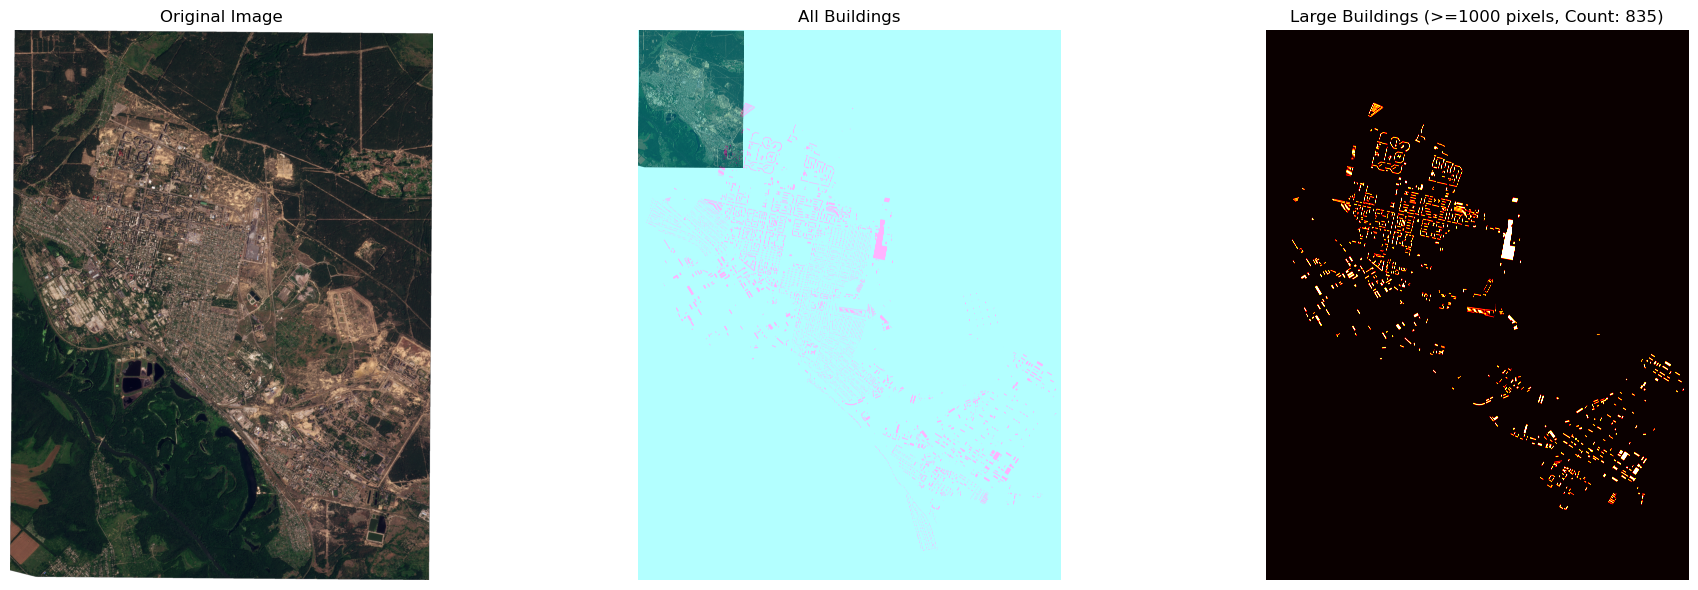


Building Statistics (Threshold: 1000 pixels):
Number of Large Buildings (>=1000 pixels): 835
Total Number of Buildings: 6740
Proportion of Large Buildings: 12.4%
Average Area of Large Buildings: 2655.17 pixels
Average Area of All Buildings: 512.17 pixels
Minimum Building Area: 12 pixels
Maximum Building Area: 180313 pixels


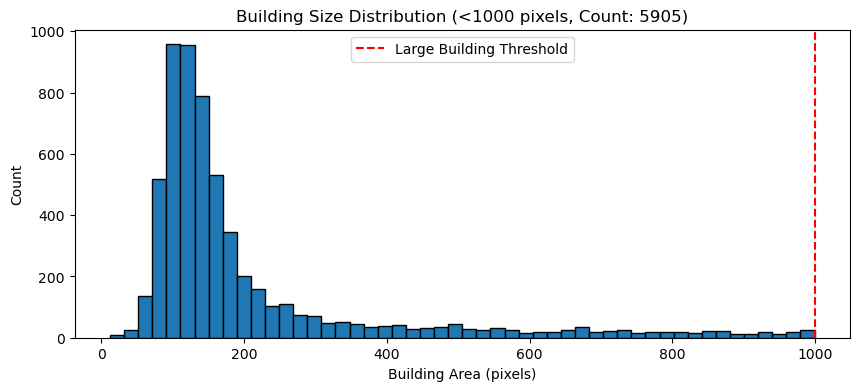

In [5]:
# 使用示例
# 可以尝试不同的阈值\
thresholds = [1000]
for threshold in thresholds:
    show_fixed_threshold('../images/20210709_073742_79_2431_3B_Visual_clip.tif', 
                        '../buildingmasks/mask_Rubizhne.tif',
                        threshold=threshold)